## Phân biệt các email giữa spam hoặc bình thường bằng văn bản chứa trong nó


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.decomposition import TruncatedSVD
import joblib

In [4]:
df = pd.read_csv("spam_ham_dataset.csv")
print(df.head())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


5 mẫu dữ liệu random

In [5]:
print(df.sample(5))

      Unnamed: 0 label                                               text  \
4827        4231  spam  Subject: - want a new laptop ? - get one free ...   
4257        3995  spam  Subject: birthplace\r\nfeldman , ! , online do...   
2734        1608   ham  Subject: budget help ! !\r\nsalaries , salarie...   
3300        1332   ham  Subject: july activity driver survey\r\nwe are...   
5003         244   ham  Subject: meter 9699\r\njackie -\r\ni cannot fo...   

      label_num  
4827          1  
4257          1  
2734          0  
3300          0  
5003          0  


## Data Preprocessing  



In [6]:
# Thay thế các ký tự xuống dòng và tiền tố "Subject:"
df['text'] = df['text'].str.replace("\r\n", " ", regex=False)
df['text'] = df['text'].str.replace("Subject:", "", regex=False).str.strip()
print(df.head())

   Unnamed: 0 label                                               text  \
0         605   ham  enron methanol ; meter # : 988291 this is a fo...   
1        2349   ham  hpl nom for january 9 , 2001 ( see attached fi...   
2        3624   ham  neon retreat ho ho ho , we ' re around to that...   
3        4685  spam  photoshop , windows , office . cheap . main tr...   
4        2030   ham  re : indian springs this deal is to book the t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


## Building Model  
Đầu tiên, thực hiện vector hóa dữ liệu đầu vào bằng `CountVectorizer`, nhằm mục đích chuyển đổi dữ liệu văn bản thành biểu diễn số. `CountVectorizer` tạo ra một vốn từ vựng gồm các từ xuất hiện trong tập dữ liệu và tạo ra một vector tương ứng cho mỗi mẫu, biểu diễn tần suất xuất hiện của các từ trong mẫu đó.


In [7]:
# Tạo Bag of Words với CountVectorizer, loại bỏ stop words tiếng Anh
count_vect = CountVectorizer(stop_words="english")
X_counts = count_vect.fit_transform(df['text'])
print("Chiều của vector hóa:", X_counts.shape)

Chiều của vector hóa: (5171, 50140)


Tiếp theo, áp dụng thuật toán TF-IDF cho vectơ thu được. Đầu ra là một sparse matrix nhưng đã được điều chỉnh theo độ hiếm của từng từ.


In [8]:
# Chuyển đổi sang TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("Chiều của TF-IDF:", X_tfidf.shape)

Chiều của TF-IDF: (5171, 50140)


# Alternative:
Chúng ta có thể tạo dữ liệu n-gram bằng cách sử dụng đối số `ngram_range` trong `CountVectorizer`, cho phép chương trình nắm bắt các cụm từ n-word thường gặp trong tập dữ liệu.

Ngoài ra, chúng ta có thể sử dụng wrapper `TfidfVectorizer` để kết hợp giữa việc vector hóa và áp dụng thuật toán TF-IDF.


In [9]:
# Tạo TF-IDF với TfidfVectorizer, sử dụng n-gram từ 1 đến 2 và loại bỏ stop words tiếng Anh
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words="english")
X_tfidf2 = tfidf_vect.fit_transform(df['text'])
print("Chiều của TfidfVectorizer:", X_tfidf2.shape)

Chiều của TfidfVectorizer: (5171, 289857)


Sau khi thực hiện vector hóa, chia tập dữ liệu train, test với tỷ lệ 8-2 để đánh giá hiệu suất








In [10]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra, tỉ lệ 80-20, stratify theo nhãn
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf2, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# TF-IDF + MultinomialNB

In [11]:
from sklearn.naive_bayes import MultinomialNB
# Huấn luyện Multinomial Naive Bayes và dự đoán
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_proba = mnb.predict_proba(X_test)[:,1]

## Số liệu và trực quan hóa  
Sử dụng F1 score để đánh giá mô hình vì phân phối lớp trong tập dữ liệu không cân bằng (với 25% thư rác).

Ngoài ra, vẽ đường cong ROC-AUC để hình dung các điểm cắt khác nhau cho mô hình.


Độ chính xác: 0.8888888888888888
F1 Score: 0.7628865979381443
ROC AUC: 0.9993968253968254


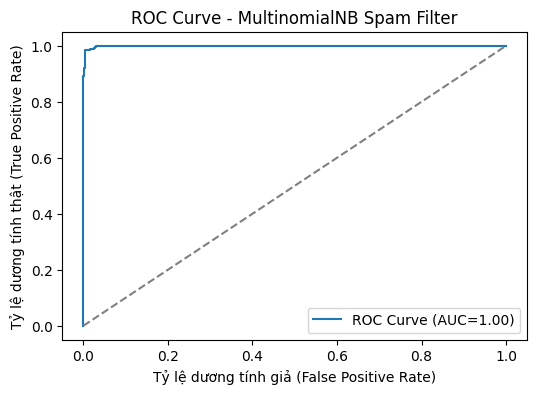

In [12]:
# Accuracy và F1-score
print("Độ chính xác:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", auc)

# Vẽ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("Tỷ lệ dương tính giả (False Positive Rate)")
plt.ylabel("Tỷ lệ dương tính thật (True Positive Rate)")
plt.title("ROC Curve - MultinomialNB Spam Filter")
plt.legend()
plt.show()

## Alternative: Co-occurrence và TruncatedSVD  

Có thể xây dựng ma trận đồng xuất hiện (co-occurrence matrix) để ghi lại sự xuất hiện đồng thời của các từ trong câu. Cho phép biểu diễn các từ trong một không gian vector dùng chung, thay vì chỉ dựa vào tần suất xuất hiện chung.  


In [13]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_counts)

X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(
    X_svd, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

gnb_svd = GaussianNB()
gnb_svd.fit(X_train_svd, y_train_svd)
y_pred_svd = gnb_svd.predict(X_test_svd)
print("Co-occurrence + SVD - Accuracy:", accuracy_score(y_test_svd, y_pred_svd))
print("Co-occurrence + SVD - F1:", f1_score(y_test_svd, y_pred_svd))

Co-occurrence + SVD - Accuracy: 0.8714975845410629
Co-occurrence + SVD - F1: 0.744721689059501


## Alternative: HashingVectorizer  

Đối với bộ dữ liệu lớn thì việc dùng `CountVectorizer` để lưu trữ dữ liệu vector hóa chiếm nhiều tài nguyên. Thay vào đó, ta có thể sử dụng `HashingVectorizer` ánh xạ nhiều từ vào cùng một ID thông qua hàm băm (hashing function).


In [14]:
from sklearn.feature_extraction.text import HashingVectorizer

# HashingVectorizer không cần fit -> trực tiếp transform
hash_vect = HashingVectorizer(n_features=5000, alternate_sign=False, stop_words="english")
X_hash = hash_vect.transform(df['text'])

# Train/test split
X_train_hash, X_test_hash, y_train_hash, y_test_hash = train_test_split(
    X_hash, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# Train MultinomialNB trên dữ liệu Hashing
mnb_hash = MultinomialNB()
mnb_hash.fit(X_train_hash, y_train_hash)
y_pred_hash = mnb_hash.predict(X_test_hash)
print("HashingVectorizer - Accuracy:", accuracy_score(y_test_hash, y_pred_hash))
print("HashingVectorizer - F1:", f1_score(y_test_hash, y_pred_hash))

HashingVectorizer - Accuracy: 0.9526570048309179
HashingVectorizer - F1: 0.9176470588235294


## So sánh giữa các phương pháp trích xuất đặc trưng


=== Comparison Summary ===
                             Method  Accuracy  F1 Score
0            TF-IDF + MultinomialNB  0.888889  0.762887
1  Co-occurrence + SVD + GaussianNB  0.871498  0.744722
2           Hashing + MultinomialNB  0.952657  0.917647


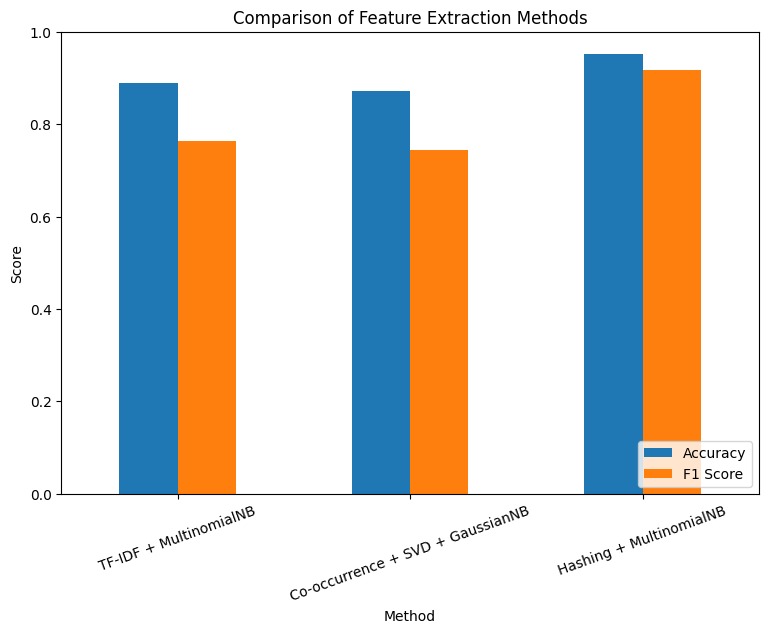

In [15]:
# Tổng hợp kết quả từ các mô hình
results = pd.DataFrame({
    "Method": [
        "TF-IDF + MultinomialNB",
        "Co-occurrence + SVD + GaussianNB",
        "Hashing + MultinomialNB"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test_svd, y_pred_svd),
        accuracy_score(y_test_hash, y_pred_hash)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test_svd, y_pred_svd),
        f1_score(y_test_hash, y_pred_hash)
    ]
})

print("\n=== Comparison Summary ===")
print(results)

# Vẽ biểu đồ so sánh
results.set_index("Method")[["Accuracy", "F1 Score"]].plot(
    kind="bar", figsize=(9,6), rot=20
)
plt.title("Comparison of Feature Extraction Methods")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

### Nhận xét:
- **TF-IDF + MultinomialNB**: Phổ biến cho bài toán lọc spam. Hiệu quả ổn định, dễ triển khai, có thể mở rộng với n-gram.  

- **Co-occurrence + TruncatedSVD + GaussianNB**: Tận dụng mối quan hệ ngữ nghĩa (các từ thường đi cùng nhau). Việc giảm chiều bằng **SVD** giúp mô hình nhẹ hơn.   

- **HashingVectorizer + MultinomialNB**: Cho kết quả **tốt nhất** cả về Accuracy và F1.

In [16]:
# TF-IDF + MultinomialNB
joblib.dump(mnb, "model_tfidf_nb.pkl")
joblib.dump(tfidf_vect, "vectorizer_tfidf.pkl")

# Co-occurrence + TruncatedSVD + GaussianNB
joblib.dump(gnb_svd, "model_svd_gnb.pkl")
joblib.dump(svd, "svd_transformer.pkl")
joblib.dump(count_vect, "vectorizer_count.pkl")

# Hashing + MultinomialNB
joblib.dump(mnb_hash, "model_hash_nb.pkl")
joblib.dump(hash_vect, "vectorizer_hash.pkl")

['vectorizer_hash.pkl']

In [25]:
loaded_mnb = joblib.load("model_tfidf_nb.pkl")
loaded_tfidf = joblib.load("vectorizer_tfidf.pkl")

sample = ["Congratulations, you won a free iPhone!"]
X_sample = loaded_tfidf.transform(sample)
print("TF-IDF NB Prediction:", loaded_mnb.predict(X_sample)[0])


TF-IDF NB Prediction: 0
